In [3]:
import jax 
import ticktack
import matplotlib.pyplot as pyplot
# import jupyterthemes
import functools

import seaborn
seaborn.set(style="ticks", context="talk")
pyplot.style.use("dark_background")
# jupyterthemes.jtplot.style()

In [4]:
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

MATRIX = model._matrix
PROJECTION = model._production_coefficients

del model

In [5]:
def load(filename: str, /, sep: str=","):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        _ = next(data)              # Header row for the data 

        data = jax.numpy.array(
            [row.strip().split(sep) for row in data], 
            dtype=jax.numpy.float64
        )
        
        return data.T

In [6]:
time_out = jax.numpy.linspace(0, 10, 100)

In [7]:
multiply = jax.jit(jax.vmap(jax.numpy.multiply, in_axes=(None, 0)))
matrix_multiply = jax.jit(jax.vmap(jax.numpy.matmul, in_axes=(0, None)))

In [8]:
eigenvals, eigenvecs = jax.numpy.linalg.eig(MATRIX)
eigenvecs, eigenvals = eigenvecs.real, eigenvals.real
inverse = jax.numpy.linalg.inv(eigenvecs)
initial_position = 1.0 / jax.numpy.linalg.norm(PROJECTION) * PROJECTION

In [9]:
@jax.jit
def fundamental_matrix(time_out, /, eigenvecs=eigenvecs, eigenvals=eigenvals, inverse=inverse):
    """
    This constructs the right hand side of the fundamental solution matrix. It is vectorised and so returns a three dimensional array with the third dimension spanning the time series implied by `time_out`.

    Parameters:
    -----------
    : time_out :  The time series over which the fundamental matrix is to be calculated
    : eigenvecs : The eigenvectors of the transfer matrix
    : eigenvals : The eigenvalues of the transfer matrix
    : inverse : The inverse of the eigenvectors of the transfer matrix. This could be calculated internally but since the evaluation is only required once it is passed as an argument.

    Returns:
    --------
    : DeviceArray : The fundamental solution matrix evaluated over the time series implied by `time_out`
    """
    # So I need to implement the translation of the time series back onto 0
    exponents = jax.numpy.exp(multiply(eigenvals, time_out))
    transition_matrix = multiply(eigenvecs, exponents)
    transition_matrix = matrix_multiply(transition_matrix, inverse)
    return transition_matrix

In [10]:
@jax.jit
def analytic_template(time_out, /, initial_poisition=initial_position):
    """
    Determines the analytic solution of an impulse response function over the time series provided by `time_out`.

    Parameters:
    -----------
    : time_out : The time series at which the analytic solution is to be evaluated
    : inverse : The inverse of the eigenvectors of the transfer matrix
    
    """
    transition_matrix = fundamental_matrix(time_out - time_out.min())
    return matrix_multiply(transition_matrix, initial_poisition)

In [11]:
intcal = load("/home/jordan/Documents/ticktack/src/data/datasets/IntCal20/Intcal20.csv")

In [40]:
@jax.jit
def linear_design_matrix(time_series):
    """
    This generates the design matrix for a simple linear regression with a constant
    and a linear coefficient.
    
    parameters:
    -----------
    : time_series : A time series to generate a normalised design matrix over
    
    returns:
    --------
    : Array : The design matrix is n by 2 where n is the leding dimension of the 
        input array.
    """
    constant = jax.numpy.ones((time_series.shape), dtype=jax.numpy.float64)
    temporal = (time_series - time_series.min()) / time_series.ptp()
    return jax.numpy.stack([constant, temporal])

Honestly I can back seat the one below since I will not need it. Actually it might make the three dimensional array slicing much easier.

In [64]:
@jax.jit
def design_matrix(time_series):
    """
    Constructs the design matrix of the linear regression. 
    
    Parameters:
    -----------
    : time_series : The time over which to evaluate the design matrix.
    
    Returns:
    --------
    : DeviceArray : A 3 by n matrix where n is the length of `time_series`.
    """
    base_fit = linear_design_matrix(time_series)
    analytic = analytic_template(time_series)[:, 1]
    return jax.numpy.vstack([base_fit, analytic])

In [66]:
# These are all utility functions for the bad boy 
# The in_window function is causing headaches because it cannot be passed the data

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This is where the error seems to be
@jax.jit
def in_window(start, times, size):
    @jax.vmap
    def comp_util(start):
        return (times >= start) & (times <= (start + size))
    return comp_util(start)

vec_lin_mat = jax.jit(jax.vmap(linear_design_matrix))
vec_ana_mat = jax.jit(jax.vmap(design_matrix)) # Vectorising the deisgn matrix command
vec_reg_fun = jax.jit(jax.vmap(jax.numpy.linalg.lstsq)) # Vectorising the lstq function 
vec_mat_mul = jax.jit(jax.vmap(jax.numpy.matmul))
vec_nonzero = jax.jit(jax.vmap(functools.partial(jax.numpy.nonzero, size=1)))

So the plan is to refactor the vec_regression so that it takes start as a parameter and data is passed as a kwarg. This is hopefully not too hard and should lead to major improvements. Hopefully making the debugging of the nans easier

In [106]:
@jax.jit
def vec_regression(data, /, size: int=100):
    """
    This is a function that performs the injection recovery over the entire
    data set at once. It uses some rather complex vectorisation stratergies 
    and is proving very frustrating.
    
    parameters:
    -----------
    : start : An array of the points to inject the events at
    : data : The data that the injected events are to be assessed against
    : size : The size of the slidign window for the event through the data
    
    returns:
    --------
    : Array : The coefficients of a linear regression along with a time stamp 
        and the chi squared of the fit. The first element of the return array 
        is the time stamp and the next three are the coefficients of the constant 
        term the linear term and the analytic impulse repsonse. The final term is 
        the chi squared.
    """
    # Repeating the data aling a third axis. This allows for the vectorisation of 
    # the code.
    batch_size = data[0].size
    num_inject = batch_size - 10

    batch = jax.numpy.expand_dims(data, axis=2)
    batch = jax.numpy.tile(batch, num_inject)
    batch = jax.numpy.transpose(batch, axes=(2, 0, 1))

    # We can make the assumption that they are all within 25 years of each other 
    # because the worst resolution is decadal. We can scan linearly through the 
    # array because it is sorted.
    start = data[0, :num_inject]

    # Boolean masks that are 1, 100. There should be one for each start
    # This means that the leading axis should have a size of dimension
    windows = in_window(start, times=data[0], size=size)
    windows = jax.numpy.expand_dims(windows, axis=1)

    # Entry points to get the fill value. There should be one for every start time
    indices = in_window(start, times=data[0], size=0)
    indices = vec_nonzero(indices)[0]

    # These are the values that overdetermine the least squares solution. 
    fill = jax.numpy.take(batch[0, :, :], indices, axis=1)
    fill = jax.numpy.tile(fill, batch_size)
    fill = jax.numpy.transpose(fill, axes=(1, 0, 2))

    # The overdetermined data for the periods in a three dimensional array.
    period = jax.numpy.where(windows, batch, fill)

    linear = vec_lin_mat(period[:, 0, :]) # This is the linear design matrix
    linear = jax.numpy.transpose(linear, axes=(0, 2, 1)) # Broadcast dimensions

    lin_lst_sq = vec_reg_fun(simple, period[:, 1, :])[0] # Determine coefficients
    lin_fitted = vec_matmul(linear, lin_lst_sq) # Generate the models 

    lin_chi_sq = (period[:, 1, :] - lin_fitted) ** 2 / period[:, 2, :] ** 2 # Calculating the linear chisquared
    lin_chi_sq = jax.numpy.sum(lin_chi_sq, axis=1) # Summing along the appropriate axis

    # The desing matrixes for the linear regression. There is one for each 
    # start year and they are 3 by the batch_size
    analytic = vec_ana_mat(period[:, 0, :]) # This is the anaytic design matrix
    analytic = jax.numpy.transpose(analytic, axes=(0, 2, 1))

    ana_lst_sq = vec_reg_fun(analytic, period[:, 1, :])[0]
    event_size = ana_lst_sq[:, 2]
    ana_fitted = vec_matmul(analytic, ana_lst_sq) 

    ana_chi_sq = (period[:, 1, :] - ana_fitted) ** 2 / period[:, 2, :] ** 2 # Calculating the linear chisquared
    ana_chi_sq = jax.numpy.sum(ana_chi_sq, axis=1) # Summing along the appropriate axis

    delta_chi_sq = ana_chi_sq - lin_chi_sq
    return jax.numpy.vstack([start, event_size, delta_chi_sq])

In [15]:
# So this will be the mask/index getter function. 
# I need to work out how to jit this bastard
def mask(condition, data):
    """
    The data needs to be passed such that the leading dimension is along 
    the zero axis. This function returns the data where the condition is 
    true.
    
    parameters:
    -----------
    : condition : A boolean array true where the data is to be returned 
    : data : A data array passed so that the leading dimension is on axis 0
    
    returns:
    : Array : The data where condition was true and nothing otherwise
    """
    # Note I will need to work out how to pass the leading dimesnion 
    indices = jax.numpy.arange(data[0].size) # Row indexes of nans
    indices = (indices * condition).nonzero()[0] # only nan indexes
    return jax.numpy.take(data.T, indices, axis=0) # cleaned data 

In [95]:
# This cell sorts the intcal data
indices = jax.numpy.argsort(intcal, axis=1)[0] # Making life a bit easier
intcal = jax.numpy.take(intcal, indices, axis=1)

In [96]:
# This cell batches the data into 16 groups 
batches = jax.numpy.resize(intcal, (3, 461, 16))
batches = jax.numpy.transpose(batches, (2, 0, 1))

In [111]:
output = jax.numpy.hstack([vec_regression(batch) for batch in batches])

Text(0.5, 1.0, '$\\Delta \\chi^{2}$ as Analytic take Linear')

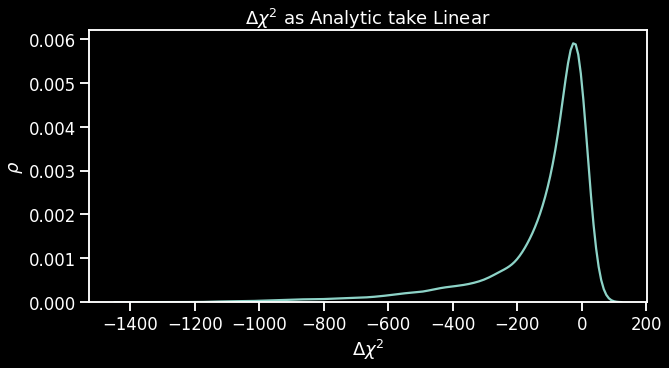

In [127]:
# This generates a distribution plot for the difference in chi-sqaured of the datab
pyplot.figure(figsize=(10, 5))
histogram = seaborn.kdeplot(output[2])
pyplot.xlabel("$\Delta \chi^{2}$")
pyplot.ylabel("$\\rho$")
pyplot.title("$\Delta \chi^{2}$ as Analytic take Linear")
# histogram.refline(x=threshold, color="red")

In [134]:
analytic_mean = jax.numpy.nanmean(output[3]) # Mean of analytic solution coefficients
analytic_std = jax.numpy.nanstd(output[3]) # Standard deviation of analytic solution coefficients

So something isn't working. I need to take out the linear solution and test it by itself first. The do the same with the analytic solution. I think I need to unit the vec_regression function solely to make the debugging easier

In [194]:
threshold = output[3] < (analytic_mean - 5.2 * analytic_std) # A mask for cutoff at 2sd
threshold = mask(threshold, output)

In [195]:
threshold

DeviceArray([[ 1602.        ,    17.80509647, -1243.59694926],
             [ 1606.        ,     8.42054888, -1351.40133108],
             [ 1614.5       ,    -4.52168073, -1125.80112128],
             [ 1607.        ,     2.62705351, -1119.84516115],
             [ 1604.5       ,    17.44176495, -1084.31156544],
             [ 1608.        ,     8.66527091, -1086.98902887],
             [ 1365.        ,    42.94336294, -1126.36071062],
             [ 1614.5       ,     6.07722999, -1095.28859921],
             [ 1618.        ,    10.49805276, -1183.11980757],
             [ 1618.        ,    -5.1853263 , -1123.86457579]],            dtype=float64)

In [186]:
val = threshold[2, 0]
val

DeviceArray(1614.5, dtype=float64)

In [187]:
sample = (intcal[0] > (val_min - 25)) & (intcal[0] < (val + 25))
sample = mask(sample, intcal).T

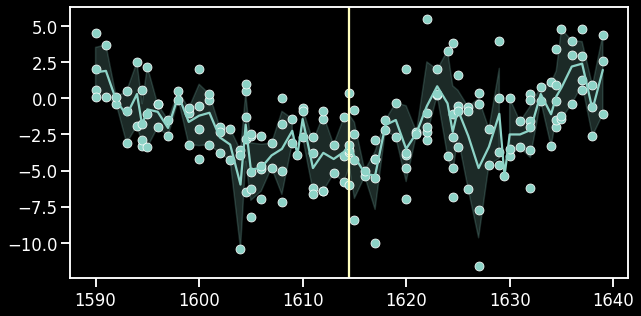

In [188]:
pyplot.figure(figsize=(10, 5))
seaborn.lineplot(x=sample[0], y=sample[1])
seaborn.scatterplot(x=sample[0], y=sample[1])
pyplot.vlines(val, ymin=-25, ymax=100, color="#FFFFBF")

The next job is to zoom in on the period of 50  years surrounding each event 

In [284]:
test_time = threshold_vals[15] # Getting a test datapoint to check with 
time_mask = ((test_time[0] - 25) < intcal[0]) & (intcal[0] < (test_time[0] + 25))
segment = mask(time_mask, intcal)

time_vals = jax.numpy.linspace(test_time[0], test_time[0] + 10, 100)
design = design_matrix(time_vals)
model = test_time[1:-1] @ design

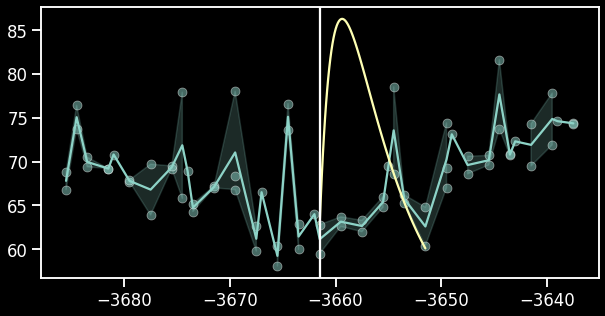

In [286]:
figure, axes = pyplot.subplots(figsize=(10, 5))
seaborn.lineplot(x=segment[:, 0], y=segment[:, 1], ax=axes)
seaborn.scatterplot(x=segment[:, 0], y=segment[:, 1], ax=axes, alpha=0.5)
seaborn.lineplot(x=time_vals, y=model, ax=axes)
pyplot.axvline(x=test_time[0])

In [ ]:
def plot_model(coeffs, alpha):
    time = jax.numpy.linspace(coeffs[0], coeffs[0] + size, 100)
    design = design_matrix(time)
    model = coeffs[1:-1] @ design
    pyplot.plot(time, model, color="#FFFFBF", alpha=alpha)

pyplot.figure(figsize=(10, 5))
pyplot.scatter(batch[0, 300:], batch[1, 300:])
pyplot.xlabel("time")
pyplot.ylabel("dc14")
pyplot.title("injection recovery on miyake data")
pyplot.ylim((0, 200))

alphas = (coeffs[:, 3].max() - coeffs[:, 3]) / coeffs[:, 3].ptp()
alphas = 1 - alphas
# alphas = map(float, alphas)

for coeff, alpha in zip(coeffs[300:], alphas[300:]):
    plot_model(coeff, float(alpha))